# Soybean-Dataset-Project_Models

###Progetto di Intelligenza Artificiale II - A.A. 2025/2026

Gruppo di Lavoro:

*   Riccardo Romano (Matricola: 2126461)
*   Hera Polegri    (Matricola: 2153537)
*   Gabriele Savo   (Matricola: 2158430)






----------

### TEST PRELIMINARE e DATA LOAD


In [3]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()

assert "data.csv" in uploaded

df = pd.read_csv(io.BytesIO(uploaded["data.csv"]))

print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Saving data.csv to data.csv
Loaded shape: (320, 11)
Columns: ['Season', 'Cultivar', 'Repetition', 'PH', 'IFP', 'NLP', 'NGP', 'NGL', 'NS', 'MHG', 'GY']


,Season,Cultivar,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
0,1,NEO 760 CE,1,58.80,15.20,98.2,177.80,1.81,5.2,152.20,3232.82
1,1,NEO 760 CE,2,58.60,13.40,102.0,195.00,1.85,7.2,141.69,3517.36
2,1,NEO 760 CE,3,63.40,17.20,100.4,203.00,2.02,6.8,148.81,3391.46
3,1,NEO 760 CE,4,60.27,15.27,100.2,191.93,1.89,6.4,148.50,3312.58
4,1,MANU IPRO,1,81.20,18.00,98.8,173.00,1.75,7.4,145.59,3230.99


In [4]:
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum())

print("\nBasic stats on target GY:")
print(df["GY"].describe())


Season          int64
Cultivar       object
Repetition      int64
PH            float64
IFP           float64
NLP           float64
NGP           float64
NGL           float64
NS            float64
MHG           float64
GY            float64
dtype: object

Missing values per column:
Season        0
Cultivar      0
Repetition    0
PH            0
IFP           0
NLP           0
NGP           0
NGL           0
NS            0
MHG           0
GY            0
dtype: int64

Basic stats on target GY:
count     320.000000
mean     3418.553794
std       503.003602
min      1538.230000
25%      3126.611552
50%      3397.276724
75%      3708.262931
max      4930.000000
Name: GY, dtype: float64


----------

## Definizione del problema

L’obiettivo di questo progetto è prevedere la **resa in grano (GY)** delle piante di soia
a partire da caratteristiche morfologiche e agronomiche misurate durante il ciclo di crescita,
insieme a informazioni di contesto come la varietà coltivata (cultivar) e la stagione.

Il problema affrontato è un caso di **apprendimento supervisionato di tipo regressione** su dati tabellari:
- le **variabili di input (X)** descrivono le caratteristiche della pianta e il contesto sperimentale;
- la **variabile target (y)** è la resa finale in grano(`GY`), una variabile numerica continua.

Il dataset contiene **320 osservazioni**, relative a **40 cultivar di soia** valutate in **due stagioni di crescita**,
con **quattro repliche sperimentali** per ciascuna combinazione cultivar–stagione.


In [5]:
# 1) Definizione delle feature e del target


TARGET = "GY"

# Variabili categoriali (da codificare)
CATEGORICAL_FEATURES = ["Season", "Cultivar"]

# Variabili numeriche
NUMERICAL_FEATURES = [
    "Repetition",
    "PH",
    "IFP",
    "NLP",
    "NGP",
    "NGL",
    "NS",
    "MHG"   # Peso di mille semi (TSW nel paper, indicato come MHG nel CSV)
]

X = df[CATEGORICAL_FEATURES + NUMERICAL_FEATURES]
y = df[TARGET]

print("Dimensione X:", X.shape)
print("Dimensione y:", y.shape)


Dimensione X: (320, 10)
Dimensione y: (320,)


***N.B:***

* Season e Cultivar sono variabili categoriali, anche se nel CSV una è numerica

* MHG corrisponde al Thousand Seed Weight (TSW) descritto nel paper

* Repetition è inclusa per modellare la variabilità sperimentale

In [7]:
# 2) Suddivisione in training set e test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Numero di campioni nel training set:", X_train.shape[0])
print("Numero di campioni nel test set:", X_test.shape[0])


Numero di campioni nel training set: 256
Numero di campioni nel test set: 64


***Questo step serve a:***

* simulare dati mai visti dal  modello

* valutare la capacità di generalizzazione

## Preprocessing dei dati

Il dataset contiene variabili di natura diversa, che richiedono un trattamento differenziato
prima di essere fornite ai modelli di machine learning:

- **Variabili numeriche**: vengono utilizzate così come sono; per alcuni modelli lineari
  può essere utile applicare una normalizzazione.
- **Variabili categoriali**: vengono trasformate tramite *one-hot encoding*, in modo da
  rappresentare correttamente categorie nominali come la cultivar e la stagione.

Per garantire una pipeline riproducibile ed evitare data leakage, tutte le trasformazioni
vengono incapsulate all’interno di un oggetto `Pipeline` di scikit-learn.


In [8]:
# 3) Preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Preprocessing per le variabili numeriche:
# - StandardScaler utile soprattutto per modelli lineari (es. Ridge)
numeric_transformer = StandardScaler()

# Preprocessing per le variabili categoriali:
# - One-Hot Encoding
categorical_transformer = OneHotEncoder(
    drop="first",      # evita collinearità
    handle_unknown="ignore"
)

# ColumnTransformer che applica trasformazioni diverse a colonne diverse
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERICAL_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES)
    ]
)



***Dati pronti per essere inseriti nei modelli***

Cultivar → ~39 colonne binarie

Season → 1 colonna binaria

numeriche → scalate

(il modello non vede più etichette, ma solo numeri)

## Modello baseline: Ridge Regression

Come primo modello utilizziamo una **Ridge Regression**, ovvero una regressione lineare
con regolarizzazione L2.

Questo modello rappresenta una buona *baseline* perché:
- è semplice e interpretabile;
- riduce il rischio di overfitting grazie alla regolarizzazione;
- permette di valutare se la relazione tra feature e resa è approssimativamente lineare.

Il modello viene inserito all’interno di una pipeline che include anche il preprocessing,
così da evitare data leakage e garantire una valutazione corretta.


In [9]:
# 4) Modello baseline: Ridge Regression


from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Pipeline completa: preprocessing + modello
ridge_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", Ridge(alpha=1.0))
    ]
)

# alpha controlla l’intensità della regolarizzazione
# partiamo con un valore standard (1.0)*

In [10]:
# Valutazione con cross-validation sul training set
cv_scores = cross_val_score(
    ridge_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

# Convertiamo in MAE positivo
mae_scores = -cv_scores

print("MAE (cross-validation) - Ridge:")
print("Media:", mae_scores.mean())
print("Deviazione standard:", mae_scores.std())


MAE (cross-validation) - Ridge:
Media: 317.52799110377026
Deviazione standard: 48.06983444261054


***Perché MAE?***

* è facile da interpretare

* è robusta

* perfetta per regressione agronomica

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Import numpy for sqrt

# Addestramento sul training set completo
ridge_pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred_ridge = ridge_pipeline.predict(X_test)

# Metriche sul test set
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
# Calculate RMSE by taking the square root of MSE
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2 = r2_score(y_test, y_pred_ridge)

print("Prestazioni Ridge Regression (test set):")
print(f"MAE:  {ridge_mae:.2f}")
print(f"RMSE: {ridge_rmse:.2f}")
print(f"R²:   {ridge_r2:.3f}")

Prestazioni Ridge Regression (test set):
MAE:  276.64
RMSE: 349.85
R²:   0.527


***Risultati della Ridge (BASELINE) Cross-validation (training)***

MAE medio ≈ 318

deviazione ≈ 48

* *Interpretazione:*

errore medio di circa ±300 kg/ha

variabilità non enorme = modello stabile

***Risultati della Ridge Regression***

Test set (dati mai visti):

MAE ≈ 277 kg/ha

RMSE ≈ 350 kg/ha

R² ≈ 0.53

* ***Interpretazione:***

In media il modello sbaglia di ~270–300 kg/ha sulla resa.

Spiega circa il 53% della varianza della resa (GY).

Considerando che il dataset piccolo (320 osservazioni), una forte variabilità biologica,
il problema reale e rumoroso, **risulta essere un’ottima baseline**.

***N.B:***

Un modello lineare regolarizzato riesce già a spiegare una parte significativa della resa, ma è plausibile che relazioni non lineari e interazioni tra feature possano migliorare le prestazioni.

## Modello non lineare: Random Forest Regressor

Come secondo modello utilizziamo una **Random Forest Regressor**, un metodo di ensemble
basato su alberi decisionali.

Questo modello è in grado di:
- catturare **relazioni non lineari** tra le variabili;
- modellare **interazioni complesse** tra feature;
- gestire bene dataset tabellari con un numero limitato di osservazioni.

Il confronto con la Ridge Regression permette di valutare se la maggiore complessità
del modello porta a un miglioramento significativo delle prestazioni.


In [12]:
# 5) Modello: Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ))
    ]
)


In [13]:
# Cross-validation sul training set
cv_scores_rf = cross_val_score(
    rf_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

mae_scores_rf = -cv_scores_rf

print("MAE (cross-validation) - Random Forest:")
print("Media:", mae_scores_rf.mean())
print("Deviazione standard:", mae_scores_rf.std())


MAE (cross-validation) - Random Forest:
Media: 302.2154099430576
Deviazione standard: 42.80196436342549


In [14]:
# Addestramento sul training set completo
rf_pipeline.fit(X_train, y_train)

# Predizione sul test set
y_pred_rf = rf_pipeline.predict(X_test)

# Metriche sul test set
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("Prestazioni Random Forest (test set):")
print(f"MAE:  {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R²:   {rf_r2:.3f}")


Prestazioni Random Forest (test set):
MAE:  284.51
RMSE: 357.33
R²:   0.507


La Ridge Regression:

* ha errore medio più basso

* spiega più varianza

La Random Forest:

* non migliora le prestazioni

* probabilmente soffre per il dataset piccolo, rumore biologico e numero limitato di osservazioni per cultivar

In questo caso, un modello lineare regolarizzato risulta competitivo rispetto a un modello non lineare più complesso, suggerendo che la relazione tra le variabili considerate e la resa sia in larga parte approssimabile come lineare.

In [15]:
# 6) Confronto finale dei modelli

results = pd.DataFrame({
    "Modello": ["Ridge Regression", "Random Forest"],
    "MAE_test": [ridge_mae, rf_mae],
    "RMSE_test": [ridge_rmse, rf_rmse],
    "R2_test": [ridge_r2, rf_r2]
})

results


,Modello,MAE_test,RMSE_test,R2_test
0,Ridge Regression,276.641995,349.846303,0.527302
1,Random Forest,284.510563,357.330972,0.506859


| Modello           | MAE (test) | RMSE (test) | R² (test) |
| ----------------- | ---------- | ----------- | --------- |
| **Ridge**         | **276.6**  | **349.9**   | **0.53**  |
| **Random Forest** | 284.5      | 357.3       | 0.51      |


File salvati correttamente in 'results/'


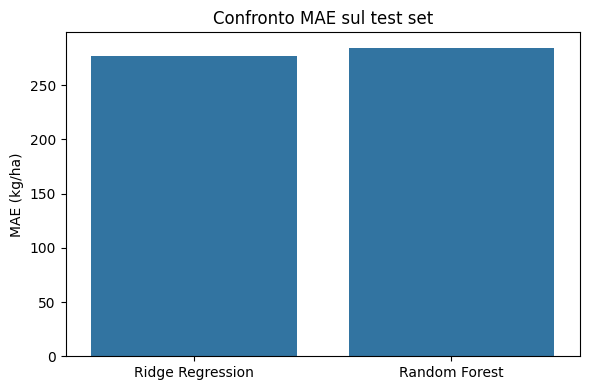

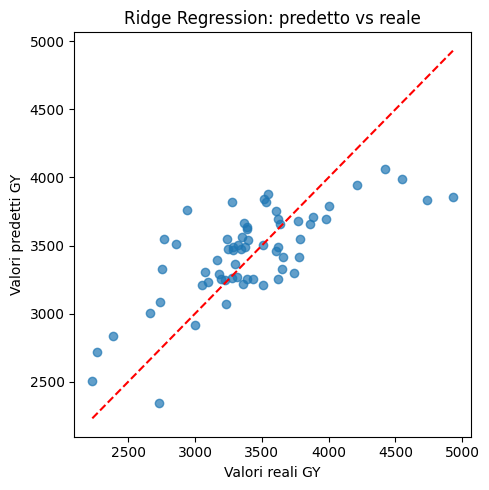

In [16]:
# 8) Salvataggio risultati

import os
import joblib

# Creiamo le cartelle se non esistono
os.makedirs("results", exist_ok=True)

# Salvataggio tabella risultati
results.to_csv("results/metrics.csv", index=False)

print("File salvati correttamente in 'results/'")


# 9) Salvataggio figure

import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("figures", exist_ok=True)

# --- Figura 1: confronto MAE ---
plt.figure(figsize=(6,4))
sns.barplot(
    x="Modello",
    y="MAE_test",
    data=results
)
plt.title("Confronto MAE sul test set")
plt.ylabel("MAE (kg/ha)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("figures/mae_comparison.png", dpi=300)
plt.show()

# --- Figura 2: predetto vs reale (Ridge) ---
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Valori reali GY")
plt.ylabel("Valori predetti GY")
plt.title("Ridge Regression: predetto vs reale")
plt.tight_layout()
plt.savefig("figures/predicted_vs_actual_ridge.png", dpi=300)
plt.show()



## Conclusioni

In questo lavoro è stato affrontato un problema di regressione supervisionata
finalizzato alla previsione della resa in grano della soia (`GY`) a partire
da caratteristiche morfologiche e informazioni di contesto.

Sono stati confrontati un modello lineare regolarizzato (Ridge Regression)
e un modello non lineare (Random Forest Regressor).
I risultati mostrano che la Ridge Regression ottiene prestazioni leggermente
migliori sul test set, suggerendo che, per questo dataset, una relazione
approssimativamente lineare tra feature e target sia sufficiente a descrivere
il fenomeno.

Questo evidenzia come, in presenza di dataset di dimensioni contenute e con
rumore biologico, modelli più semplici possano risultare competitivi rispetto
a modelli più complessi.
